## Domain adaptation

In [91]:
import fasttext
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy.stats
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [92]:
DATADIR = "../data/"
DISTANCE = "distance"
FACEMASK = "mondkapje"
TESTING = "testing"
FILEFASTTEXT = "fasttext.csv"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
LABEL = "label"
TEXT = "text"
USER = "user"
LABELPREFIX = "__label__"
LARGEINT = 9999999999

In [93]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [94]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)


def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))


def preprocess(text):
    return(tokenize(cleanup(text)).lower())


def select_annotations(tweets, annotations, target_annotator):
    fasttext_data = {}
    for i in range(0,len(annotations)):
        annotator = annotations.iloc[i][0]
        tweet_id = annotations.iloc[i][2]
        if annotator == target_annotator and tweet_id in list(tweets.index):
            tweet_user = tweets.loc[tweet_id][1]
            tweet_label = annotations.iloc[i][4]
            if tweet_label == NEUTRAL: tweet_label = IRRELEVANT
            if tweet_label == ANDERS: tweet_label = IRRELEVANT
            if tweet_label == EENS: tweet_label = SUPPORTS
            if tweet_label == ONEENS: tweet_label = REJECTS
            fasttext_data[tweet_id] = { LABEL:LABELPREFIX+tweet_label,
                                        USER:tweet_user,
                                        TEXT:preprocess(tweets.loc[tweet_id][TEXT]) }
    return(fasttext_data)


def store_fasttext_data(fasttext_data):
    outfile = open(FILEFASTTEXT, "w")
    seen_texts = {}
    fasttext_data_list = []
    tweet_ids = []
    for tweet_id in fasttext_data:
        text = cleanup(fasttext_data[tweet_id][TEXT])
        if not text in seen_texts:
            print(fasttext_data[tweet_id][LABEL], text, file=outfile)
            fasttext_data_list.append(" ".join([fasttext_data[tweet_id][LABEL], text]))
            tweet_ids.append(tweet_id)
            seen_texts[text] = True
    outfile.close()
    return(fasttext_data_list, tweet_ids)

In [95]:
def make_fasttext_data(topic):
    if topic == TESTING:
        tweet_file = DATADIR + topic + "-202003-202012.csv"
    else:
        tweet_file = DATADIR + topic + "-tweets.csv"
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)   
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")        
    main_annotator = annotations.iloc[0][0]
    fasttext_data = select_annotations(tweets, annotations, main_annotator)
    fasttext_data_list, tweet_ids = store_fasttext_data(fasttext_data)
    return(fasttext_data_list, tweet_ids)

In [96]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True,printMatrix=False):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    if printMatrix:
        print(cf)
    for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
    numberOfPredictedSupportLabels = sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))])
    numberOfGoldSupportLabels = sum(cf.loc['__label__SUPPORTS'])
    numberOfPredictedRejectLabels = sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])
    numberOfGoldRejectLabels = sum(cf.loc['__label__REJECTS'])
    if numberOfPredictedSupportLabels > 0 and numberOfGoldRejectLabels > 0 and numberOfGoldSupportLabels > 0:
        fraction = (numberOfPredictedRejectLabels/numberOfPredictedSupportLabels)/(numberOfGoldRejectLabels/numberOfGoldSupportLabels)
    else:
        fraction = LARGEINT
    if printResults: 
        print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

def runFasttext(fasttextData1,fasttextData2,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None,pretrainedVectors=None):
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [97]:
fasttext_data_list_distance, tweet_ids_distance = make_fasttext_data("distance")
fasttext_data_list_facemask, tweet_ids_facemask = make_fasttext_data("mondkapje")
fasttext_data_list_testing, tweet_ids_testing = make_fasttext_data("testing")

In [98]:
len(tweet_ids_distance), len(tweet_ids_facemask), len(tweet_ids_testing)

(5731, 578, 1181)

In [99]:
def store_fasttext_data(data, file_name):
    with open(file_name, "wb") as outfile:
        pickle.dump(data, outfile)
        outfile.close()
        
def read_fasttext_data(file_name):
    with open(file_name, "rb") as infile:
        data = pickle.load(infile)
        infile.close()
    return(data)

## Evaluation within domains (usually skipped)

In [ ]:
predictionCountsValidationDD,predictionLabelsValidationDD,predictionCountsTestDD,predictionLabelsTestDD = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestDD, "predictionLabelsTestDD.pickle")

In [50]:
predictionCountsValidationFFT,predictionLabelsValidationFFT,predictionCountsTestFFT,predictionLabelsTestFFT = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 58; precision: 0.741; recall: 0.741; fraction: 9999999999.000
1 cases: 58; precision: 0.655; recall: 0.655; fraction: 9999999999.000
2 cases: 57; precision: 0.614; recall: 0.614; fraction: 0.586
3 cases: 58; precision: 0.569; recall: 0.569; fraction: 9999999999.000
4 cases: 58; precision: 0.638; recall: 0.638; fraction: 9999999999.000
5 cases: 58; precision: 0.638; recall: 0.638; fraction: 9999999999.000
6 cases: 58; precision: 0.741; recall: 0.741; fraction: 9999999999.000
7 cases: 57; precision: 0.596; recall: 0.596; fraction: 1.192
8 cases: 58; precision: 0.672; recall: 0.672; fraction: 9999999999.000
9 cases: 58; precision: 0.586; recall: 0.586; fraction: 3.808
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  182                94                  2
__label__REJECTS                      73               191                  4
__la

In [51]:
store_fasttext_data(predictionLabelsTestFFT, "predictionLabelsTestFFT.pickle")

In [ ]:
predictionCountsValidationTT, predictionLabelsValidationTT, predictionCountsTestTT, predictionLabelsTestTT = \
    runFasttext(fasttext_data_list_testing, fasttext_data_list_testing, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestTT, "predictionLabelsTestTT.pickle")

In [ ]:
predictionCountsValidationF, predictionLabelsValidationF, predictionCountsTestF, predictionLabelsTestF = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300)

In [ ]:
predictionCountsValidationD, predictionLabelsValidationD, predictionCountsTestD, predictionLabelsTestD = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False, dim=300)

In [ ]:
predictionCountsValidationT, predictionLabelsValidationT, predictionCountsTestT, predictionLabelsTestT = \
    runFasttext(fasttext_data_list_testing, fasttext_data_list_testing, squealFlag=False, dim=300)

## Predicting social distancing with facemask data

In [100]:
def count_labels(fasttext_data_list):
    counts = {}
    for i in range(0, len(fasttext_data_list)):
        token_list = fasttext_data_list[i].split()
        if token_list[0] in counts:
            counts[token_list[0]] += 1
        else:
            counts[token_list[0]] = 1
    return(counts)


def swap_labels(fasttext_data_list_in):
    fasttext_data_list_out = []
    for i in range(0, len(fasttext_data_list_in)):
        token_list = fasttext_data_list_in[i].split()
        if token_list[0] == "__label__REJECTS":
            token_list[0] = "__label__SUPPORTS"
        elif token_list[0] == "__label__SUPPORTS":
            token_list[0] = "__label__REJECTS"
        fasttext_data_list_out.append(" ".join(token_list))
    return(fasttext_data_list_out)

In [101]:
if False:
    predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
        runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300)

In [102]:
if False:
    predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
        runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [103]:
if False:
    store_fasttext_data(predictionLabelsTestFD, "predictionLabelsTestFD.pickle")

In [104]:
predictionLabelsTestFD = read_fasttext_data("predictionLabelsTestFD.pickle")
predictionLabelsTestDD = read_fasttext_data("predictionLabelsTestDD.pickle")

In [105]:
def convert(data):
    plot_data =[]
    for key in data:
        if re.search("^[0-9]+$", str(key)):
            support_count = 0
            reject_count = 0
            for label in data[key]:
                if label == "__label__SUPPORTS":
                    support_count += 1
                if label == "__label__REJECTS":
                    reject_count += 1
            if support_count+reject_count > 0:
                plot_data.append((int(key), support_count/(support_count+reject_count)))
    plot_data = [x for x in sorted(plot_data, key=lambda x:x[0])]
    return(plot_data)

In [106]:
def make_data_predicted(predictionLabelsTest, tweet_ids, time_factor=4):
    predicted = []
    for i in range(0, len(predictionLabelsTest)):
        for j in range(0, len(predictionLabelsTest[i][0])):
            predicted.append(predictionLabelsTest[i][0][j])
    data_predicted = {}
    for i in range(0, len(tweet_ids)):
        summary = str(tweet_ids[i])[0:time_factor]
        if summary not in data_predicted:
            data_predicted[summary] = []
        data_predicted[summary].append(predicted[i][0])
    return(data_predicted)

In [107]:
time_factor = 4
data_predicted_fd = make_data_predicted(predictionLabelsTestFD, tweet_ids_distance, time_factor=time_factor)
data_predicted_dd = make_data_predicted(predictionLabelsTestDD, tweet_ids_distance, time_factor=time_factor)

In [108]:
gold = []
for tweet in fasttext_data_list_distance:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_distance)):
    summary = str(tweet_ids_distance[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

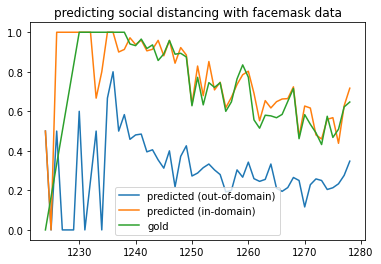

In [109]:
plot_data_predicted_fd = convert(data_predicted_fd)
plot_data_predicted_dd = convert(data_predicted_dd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Inflate predictions

In [110]:
def get_freqs(label_list):
    freqs = {}
    for label in label_list:
        if label in freqs:
            freqs[label] += 1
        else:
            freqs[label] = 1
    for label in freqs:
        freqs[label] /= len(label_list)
    return(freqs)

In [111]:
def inflate(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]*factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [112]:
def inflate_plus(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]+factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [113]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__REJECTS': 0.19822020589774908, '__label__SUPPORTS': 0.5632524864770546, '__label__IRRELEVANT': 0.2385273076251963}
0.35192069392812886


In [114]:
FACTOR = 0.9967

predictionLabelsTestFDinflated = list(predictionLabelsTestFD)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestFDinflated, '__label__SUPPORTS', '__label__REJECTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.5379514918862328, '__label__SUPPORTS': 0.34252311987436745, '__label__REJECTS': 0.11952538823939976}
0.34895568008150796


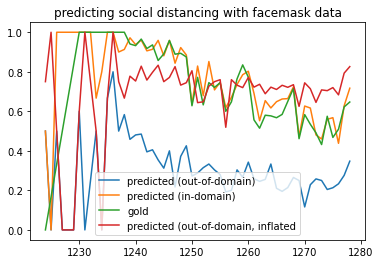

In [115]:
data_predicted_fd_inflated = make_data_predicted(predictionLabelsTestFDinflated, tweet_ids_distance)
plot_data_predicted_fd_inflated = convert(data_predicted_fd_inflated)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
x_fd_inflated = [x[0] for x in plot_data_predicted_fd_inflated]
y_fd_inflated = [x[1] for x in plot_data_predicted_fd_inflated]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_fd_inflated, y_fd_inflated, label="predicted (out-of-domain, inflated")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Numerical analysis of predictions

In [116]:
plot_data_predicted_fd_dict = { x[0]:x[1] for x in plot_data_predicted_fd }
plot_data_predicted_dd_dict = { x[0]:x[1] for x in plot_data_predicted_dd }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }
plot_data_predicted_fd_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_fd_inflated }

In [117]:
def get_common_key_values(dict1, dict2):
    values1 = []
    values2 = []
    for key in sorted(dict1.keys()):
        if key in dict2:
            values1.append(dict1[key])
            values2.append(dict2[key])
    return(values1, values2)

In [118]:
values_dd, values_gold_dd = get_common_key_values(plot_data_predicted_dd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_dd), np.array(values_dd)).rvalue, 2))
values_fd, values_gold_fd = get_common_key_values(plot_data_predicted_fd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd)).rvalue, 2))
values_fd_inflated, values_gold_fd_inflated = get_common_key_values(plot_data_predicted_fd_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd_inflated)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.88
Pearson r correlation gold vs out-of-domain: 0.47
Pearson r correlation gold vs out-of-domain (inflated): -0.06


In [119]:
def absolute_difference(list1, list2):
    absolute_difference = 0
    for i in range(0, len(list1)):
        absolute_difference += abs(list1[i]-list2[i])
    return(absolute_difference/len(list1))

In [120]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_dd, values_dd), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_fd, values_fd),2))
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_fd_inflated, values_fd_inflated),2)) 

absolute difference gold vs in-domain: 0.06
absolute difference gold vs out-of-domain: 0.42
absolute difference gold vs out-of-domain (inflated): 0.18


## Predicting facemasks with social distancing data

In [121]:
if False:
    predictionCountsValidationDF,predictionLabelsValidationDF,predictionCountsTestDF,predictionLabelsTestDF = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

In [122]:
if False:
    predictionCountsValidationDFT,predictionLabelsValidationDFT,predictionCountsTestDFT,predictionLabelsTestDFT = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [123]:
if False:
    store_fasttext_data(predictionLabelsTestDFT, "predictionLabelsTestDFT.pickle")

In [124]:
predictionLabelsTestDF = read_fasttext_data("predictionLabelsTestDF.pickle")
predictionLabelsTestFF = read_fasttext_data("predictionLabelsTestFF.pickle")

In [125]:
time_factor = 5
data_predicted_df = make_data_predicted(predictionLabelsTestDF, tweet_ids_facemask, time_factor=time_factor)
data_predicted_ff = make_data_predicted(predictionLabelsTestFF, tweet_ids_facemask, time_factor=time_factor)

In [126]:
gold = []
for tweet in fasttext_data_list_facemask:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_facemask)):
    summary = str(tweet_ids_facemask[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

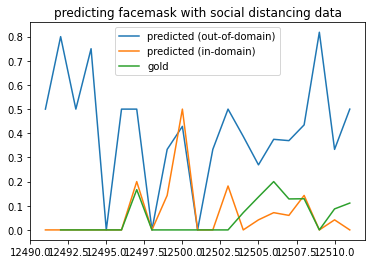

In [127]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Inflate predictions

In [128]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.4809688581314879, '__label__REJECTS': 0.46366782006920415, '__label__SUPPORTS': 0.05536332179930796}
8.375


In [129]:
FACTOR = 0.9893

predictionLabelsTestDFinflated = list(predictionLabelsTestDF)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.27760968229954613, '__label__REJECTS': 0.518910741301059, '__label__SUPPORTS': 0.20347957639939485}
2.550185873605948


In [130]:
data_predicted_df_inflated = make_data_predicted(inflate(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR), tweet_ids_facemask, time_factor=1)

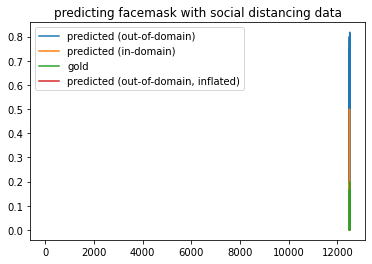

In [131]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_predicted_df_inflated = convert(data_predicted_df_inflated)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
x_df_inflated = [x[0] for x in plot_data_predicted_df_inflated]
y_df_inflated = [x[1] for x in plot_data_predicted_df_inflated]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_df_inflated, y_df_inflated, label="predicted (out-of-domain, inflated)")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Numerical analysis of predictions

In [132]:
plot_data_predicted_df_dict = { x[0]:x[1] for x in plot_data_predicted_df }
plot_data_predicted_ff_dict = { x[0]:x[1] for x in plot_data_predicted_ff }
plot_data_predicted_df_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_df_inflated }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [133]:
values_ff, values_gold_ff = get_common_key_values(plot_data_predicted_ff_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_ff), np.array(values_ff)).rvalue, 2))
values_df, values_gold_df = get_common_key_values(plot_data_predicted_df_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_df), np.array(values_df)).rvalue, 2))
values_df_inflated, values_gold_df_inflated = get_common_key_values(plot_data_predicted_df_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_df_inflated), np.array(values_df_inflated)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.05
Pearson r correlation gold vs out-of-domain: -0.11


ValueError: Inputs must not be empty.

In [44]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_ff, values_ff), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_df, values_df),2)) 
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_df_inflated, values_df_inflated),2)) 

absolute difference gold vs in-domain: 0.07
absolute difference gold vs out-of-domain: 0.37


ZeroDivisionError: division by zero

## Predicting testing data with distance data

In [134]:
if False:
    predictionCountsValidationDT, predictionLabelsValidationDT, predictionCountsTestDT, predictionLabelsTestDT = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, dim=300)

In [135]:
if False:
    predictionCountsValidationDT, predictionLabelsValidationDT, predictionCountsTestDT, predictionLabelsTestDT = \
        runFasttext(fasttext_data_list_distance, 
                    fasttext_data_list_testing, 
                    squealFlag=False, 
                    dim=300, 
                    pretrainedVectors="twiqs-model-2020.vec")

In [136]:
if False:
    store_fasttext_data(predictionLabelsTestDT, "predictionLabelsTestDT.pickle")

In [137]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")
predictionLabelsTestTT = read_fasttext_data("predictionLabelsTestTT.pickle")

In [138]:
time_factor = 3
data_predicted_dt = make_data_predicted(predictionLabelsTestDT, tweet_ids_testing, time_factor=time_factor)
data_predicted_tt = make_data_predicted(predictionLabelsTestTT, tweet_ids_testing, time_factor=time_factor)

In [139]:
gold = []
for tweet in fasttext_data_list_testing:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_testing)):
    summary = str(tweet_ids_testing[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

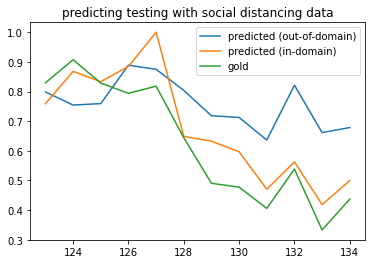

In [140]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_dt]
y_df = [x[1] for x in plot_data_predicted_dt]
x_ff = [x[0] for x in plot_data_predicted_tt]
y_ff = [x[1] for x in plot_data_predicted_tt]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Use extra data in training

In [141]:
def runFasttextPlus(fasttextData1,
                    fasttextData2,
                    dim=DIM,
                    epoch=EPOCH,
                    lr=LR,
                    n=N,
                    squealFlag=True,
                    maxTrain=None,
                    pretrainedVectors=None,
                    extraFasttextData=None):
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        if extraFasttextData != None:
            for i in range(0,len(extraFasttextData)):
                data = extraFasttextData[i]
                print(data,file=trainFile)
                trainData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [142]:
if False:
    predictionCountsValidationET, predictionLabelsValidationET, predictionCountsTestET, predictionLabelsTestET = \
        runFasttextPlus(fasttext_data_list_testing, 
                    fasttext_data_list_testing, 
                    squealFlag=False, 
                    dim=300, 
                    extraFasttextData=fasttext_data_list_distance)

In [143]:
if False:
    predictionCountsValidationET, predictionLabelsValidationET, predictionCountsTestET, predictionLabelsTestET = \
        runFasttextPlus(fasttext_data_list_testing, 
                        fasttext_data_list_testing, 
                        squealFlag=False, 
                        dim=300,
                        pretrainedVectors="twiqs-model-2020.vec",
                        extraFasttextData=fasttext_data_list_distance)

In [144]:
if False:
    store_fasttext_data(predictionLabelsTestET, "predictionLabelsTestET.pickle")

In [145]:
if False:
    predictionCountsValidationEF, predictionLabelsValidationEF, predictionCountsTestEF, predictionLabelsTestEF = \
        runFasttextPlus(fasttext_data_list_facemask, 
                        fasttext_data_list_facemask, 
                        squealFlag=False, 
                        dim=300,
                        pretrainedVectors="twiqs-model-2020.vec",
                        extraFasttextData=fasttext_data_list_distance)

In [146]:
if False:
    store_fasttext_data(predictionLabelsTestEF, "predictionLabelsTestEF.pickle")

In [147]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")
predictionLabelsTestTT = read_fasttext_data("predictionLabelsTestTT.pickle")
predictionLabelsTestET = read_fasttext_data("predictionLabelsTestET.pickle")

In [148]:
time_factor = 3
data_predicted_dt = make_data_predicted(predictionLabelsTestDT, tweet_ids_testing, time_factor=time_factor)
data_predicted_tt = make_data_predicted(predictionLabelsTestTT, tweet_ids_testing, time_factor=time_factor)
data_predicted_et = make_data_predicted(predictionLabelsTestET, tweet_ids_testing, time_factor=time_factor)

In [149]:
gold = []
for tweet in fasttext_data_list_testing:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_testing)):
    summary = str(tweet_ids_testing[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

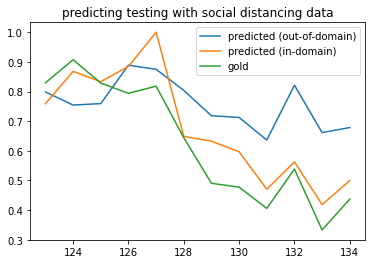

In [150]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
plt.legend()
plt.title("predicting testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Inflate predictions

In [151]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__SUPPORTS': 0.28789161727349705, '__label__IRRELEVANT': 0.5342929720575783, '__label__REJECTS': 0.17781541066892464}
0.6176470588235294


In [152]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")

In [153]:
FACTOR = 0.7957

predictionLabelsTestDTinflated = list(predictionLabelsTestDT)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestDTinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__REJECTS': 0.26418289585097376, '__label__SUPPORTS': 0.42675698560541914, '__label__IRRELEVANT': 0.3090601185436071}
0.6190476190476191


In [154]:
data_predicted_dt_inflated = make_data_predicted(inflate(predictionLabelsTestDTinflated, 
                                                         '__label__REJECTS', 
                                                         '__label__SUPPORTS', 
                                                         FACTOR), 
                                                         tweet_ids_testing, 
                                                         time_factor=time_factor)

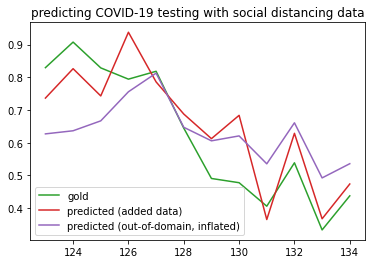

In [155]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]

#plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
#plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")

plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Removing domain-dependent words

In [70]:
predictionCountsValidationDTD, predictionLabelsValidationDTD, predictionCountsTestDTD, predictionLabelsTestDTD = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, dim=300)

0 cases: 118; precision: 0.364; recall: 0.364; fraction: 0.462
1 cases: 118; precision: 0.407; recall: 0.407; fraction: 0.614
2 cases: 118; precision: 0.432; recall: 0.432; fraction: 0.719
3 cases: 118; precision: 0.390; recall: 0.390; fraction: 0.465
4 cases: 118; precision: 0.331; recall: 0.331; fraction: 0.626
5 cases: 119; precision: 0.387; recall: 0.387; fraction: 0.553
6 cases: 118; precision: 0.432; recall: 0.432; fraction: 0.194
7 cases: 118; precision: 0.390; recall: 0.390; fraction: 0.099
8 cases: 118; precision: 0.432; recall: 0.432; fraction: 0.991
9 cases: 118; precision: 0.314; recall: 0.314; fraction: 1.359
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  197                98                336
__label__REJECTS                      70                51                 89
__label__SUPPORTS                     92                3

In [156]:
def count_tokens(tweet_list):
    counts = {}
    for tweet in tweet_list:
        for token in tweet.split()[1:]:
            if not token in counts:
                counts[token] = 0
            counts[token] += 1
    return(counts)

In [159]:
counts_train = count_tokens(fasttext_data_list_distance)
counts_test = count_tokens(fasttext_data_list_testing)
counts_train_total = sum(counts_train.values())
counts_test_total = sum(counts_test.values())
print(counts_train_total, counts_test_total)

196888 52387


In [157]:
def remove_infrequent_tokens(tweet_list_in, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=0):
    tweet_list_out = []
    token_count = 0
    for tweet in tweet_list_in:
        accepted_tokens = []
        tweet_tokens = tweet.split()
        for token in tweet_tokens[1:]:
            if token in counts_train and token in counts_test and \
               counts_train[token] / counts_train_total > minimum_frequency and \
               counts_test[token] / counts_test_total > minimum_frequency:
                accepted_tokens.append(token)
        token_count += 1 + len(accepted_tokens)
        if len(accepted_tokens) == 0:
            accepted_tokens = [ "DUMMY" ]
        tweet_list_out.append(" ".join(tweet_tokens[:1]+accepted_tokens))
    print(token_count)
    return(tweet_list_out)

In [160]:
MINFREQ = 0.0002
fasttext_data_list_distance_filtered = remove_infrequent_tokens(fasttext_data_list_distance, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=MINFREQ)
fasttext_data_list_testing_filtered = remove_infrequent_tokens(fasttext_data_list_testing, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=MINFREQ)

137571
36390


In [71]:
if False:
    predictionCountsValidationDTD, predictionLabelsValidationDTD, predictionCountsTestDTD, predictionLabelsTestDTD = \
        runFasttext(fasttext_data_list_distance_filtered, fasttext_data_list_testing, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [72]:
if False:
    store_fasttext_data(predictionLabelsTestDTD, "predictionLabelsTestDTD0.0002A.pickle")

In [161]:
predictionLabelsTestDTD = read_fasttext_data("predictionLabelsTestDTD0.0002A.pickle")

|  method | train | test | accuracy | fraction | comment |
| ------- | ----- | ---- | -------- | -------- | ------- |
| none        | 196888 | 52387 | 0.385 | 0.478 | |
| M = 0       | 171520 | 49477 | 0.379 | 0.650 | |
| M = 0.00001 | 170682 | 48139 | 0.375 | 0.650 | |
| M = 0.0001  | 145771 | 39891 | 0.379 | 0.688 | |
| M = 0.0002  | 137571 | 36390 | 0.390 | 0.833 | |
| M = 0.0003  | 127440 | 34457 | 0.359 | 0.776 | |
| M = 0.0004  | 119718 | 32913 | 0.346 | 0.764 | |
| M = 0.001   |  99965 | 28123 | 0.327 | 0.186 | |
| M = 0.01    |  46634 | 12909 | 0.289 | 0.006 | |
| M = 0.1     |   5731 |  1181 | 0.288 | 0.000 | |
| M = 0       | 171520 | 52387 | 0.381 | 0.635 | |
| M = 0.00001 | 170682 | 52387 | 0.374 | 0.637 | |
| M = 0.0001  | 145771 | 52387 | 0.378 | 0.665 | |
| M = 0.0002  | 137571 | 52387 | 0.395 | 0.860 | |
| M = 0.0003  | 127440 | 52387 | 0.358 | 0.764 | |
| M = 0.0004  | 119718 | 52387 | 0.345 | 0.769 | |
| M = 0.001   |  99965 | 52387 | 0.324 | 0.193 | |
| M = 0.01    |  46634 | 52387 | 0.290 | 0.007 | |
| M = 0.1     |   5731 | 52387 | 0.288 | 0.000 | |
| M = 0       | 171520 | 49477 | 0.393 | 0.736 | +model |
| M = 0.0002  | 137571 | 36390 | 0.385 | 0.841 | +model |
| M = 0.0002  | 137571 | 52387 | 0.380 | 0.734 | +model |

In [162]:
data_predicted_dtd = make_data_predicted(predictionLabelsTestDTD, tweet_ids_testing, time_factor=time_factor)

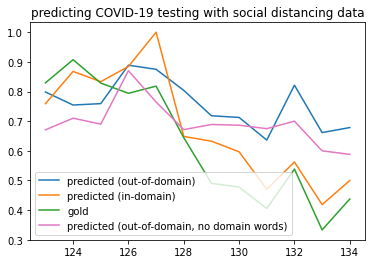

In [163]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_predicted_dtd = convert(data_predicted_dtd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]
x_dtd = [x[0] for x in plot_data_predicted_dtd]
y_dtd = [x[1] for x in plot_data_predicted_dtd]

plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
#plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")
plt.plot(x_dtd, y_dtd, label="predicted (out-of-domain, no domain words)", c="C6")

plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Training and testing on only relevant data

In [164]:
fasttext_data_list_distance_relevant = [ line for line in fasttext_data_list_distance if not re.search("^__label__IRRELEVANT", line) ]
len(fasttext_data_list_distance_relevant)

4364

In [77]:
if False:
    predictionCountsValidationT, predictionLabelsValidationT, predictionCountsTestT, predictionLabelsTestT = \
        runFasttext(fasttext_data_list_testing, fasttext_data_list_testing, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.604
1 cases: 118; precision: 0.585; recall: 0.585; fraction: 1.217
2 cases: 118; precision: 0.636; recall: 0.636; fraction: 1.166
3 cases: 118; precision: 0.593; recall: 0.593; fraction: 0.697
4 cases: 118; precision: 0.610; recall: 0.610; fraction: 1.067
5 cases: 119; precision: 0.580; recall: 0.580; fraction: 0.549
6 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.441
7 cases: 118; precision: 0.695; recall: 0.695; fraction: 0.588
8 cases: 118; precision: 0.525; recall: 0.525; fraction: 2.698
9 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.549
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  442                50                139
__label__REJECTS                      85                95                 30
__label__SUPPORTS                    152                2

In [78]:
if False:
    store_fasttext_data(predictionLabelsTestT, "predictionLabelsTestT.pickle")

In [165]:
predictionLabelsTestT = read_fasttext_data("predictionLabelsTestT.pickle")

In [166]:
fasttext_data_list_testing_relevant = []
i = 0
for fold in predictionLabelsTestT:
    for prediction_order_list in fold[0]:
        if prediction_order_list[0] != "__label__IRRELEVANT":
            tweet = re.sub("^__label__IRRELEVANT", "__label__SUPPORTS", fasttext_data_list_testing[i])
            fasttext_data_list_testing_relevant.append(tweet)
        i += 1

In [167]:
len(fasttext_data_list_distance_relevant), len(fasttext_data_list_testing_relevant)

(4364, 502)

In [181]:
if False:
    predictionCountsValidationDTR, predictionLabelsValidationDTR, predictionCountsTestDTR, predictionLabelsTestDTR = \
        runFasttext(fasttext_data_list_distance_relevant, fasttext_data_list_testing_relevant, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 50; precision: 0.660; recall: 0.660; fraction: 2.144
1 cases: 50; precision: 0.800; recall: 0.800; fraction: 0.826
2 cases: 51; precision: 0.725; recall: 0.725; fraction: 0.779
3 cases: 50; precision: 0.820; recall: 0.820; fraction: 1.092
4 cases: 50; precision: 0.660; recall: 0.660; fraction: 2.452
5 cases: 50; precision: 0.840; recall: 0.840; fraction: 1.568
6 cases: 50; precision: 0.760; recall: 0.760; fraction: 1.185
7 cases: 51; precision: 0.627; recall: 0.627; fraction: 0.664
8 cases: 50; precision: 0.740; recall: 0.740; fraction: 1.631
9 cases: 50; precision: 0.580; recall: 0.580; fraction: 6.000
 col_0              __label__REJECTS  __label__SUPPORTS
row_0                                                 
__label__REJECTS                 71                 54
__label__SUPPORTS                86                291
cases: 502; precision: 0.721; recall: 0.721; fraction: 1.372


In [182]:
if False:
    store_fasttext_data(predictionLabelsTestDTR, "predictionLabelsTestDTR.pickle")

In [183]:
predictionLabelsTestDTR = read_fasttext_data("predictionLabelsTestDTR.pickle")

In [184]:
predictionLabelsTestDTRrestored = []
fold_count = 0
for fold in predictionLabelsTestT:
    predictionLabelsTestDTRrestored.append(([[]]))
    tweet_count = 0
    for prediction_order_list in fold[0]:
        if prediction_order_list[0] == "__label__IRRELEVANT":
            predictionLabelsTestDTRrestored[-1][0].append(prediction_order_list)
        else:
            if tweet_count >= len(predictionLabelsTestDTR[fold_count][0]):
                break
            predictionLabelsTestDTRrestored[-1][0].append(predictionLabelsTestDTR[fold_count][0][tweet_count])
            tweet_count += 1
    for i in range(len(predictionLabelsTestDTRrestored[-1][0]), len(fold[0])):
        predictionLabelsTestDTRrestored[-1][0].append(fold[0][i])
    fold_count += 1
sum([len(fold[0]) for fold in predictionLabelsTestDTRrestored])

1181

In [185]:
data_predicted_dtr = make_data_predicted(predictionLabelsTestDTRrestored, tweet_ids_testing, time_factor=time_factor)

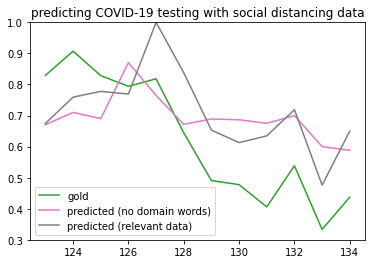

In [186]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_predicted_dtd = convert(data_predicted_dtd)
plot_data_predicted_dtr = convert(data_predicted_dtr)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]
x_dtd = [x[0] for x in plot_data_predicted_dtd]
y_dtd = [x[1] for x in plot_data_predicted_dtd]
x_dtr = [x[0] for x in plot_data_predicted_dtr]
y_dtr = [x[1] for x in plot_data_predicted_dtr]

plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
#plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
#lt.plot(x_et, y_et, label="predicted (added data)", c="C3")
#plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")
plt.plot(x_dtd, y_dtd, label="predicted (no domain words)", c="C6")
plt.plot(x_dtr, y_dtr, label="predicted (relevant data)", c="C7")

plt.ylim(0.3, 1.0)
plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Numerical analysis of predictions

In [187]:
plot_data_predicted_dt_dict = { x[0]:x[1] for x in plot_data_predicted_dt }
plot_data_predicted_tt_dict = { x[0]:x[1] for x in plot_data_predicted_tt }
plot_data_predicted_dt_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_dt_inflated }
plot_data_predicted_dtd_dict = { x[0]:x[1] for x in plot_data_predicted_dtd }
plot_data_predicted_dtr_dict = { x[0]:x[1] for x in plot_data_predicted_dtr }
plot_data_predicted_et_dict = { x[0]:x[1] for x in plot_data_predicted_et }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [188]:
values_tt, values_gold_tt = get_common_key_values(plot_data_predicted_tt_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_tt), np.array(values_tt)).rvalue, 2))
values_dt, values_gold_dt = get_common_key_values(plot_data_predicted_dt_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_dt), np.array(values_dt)).rvalue, 2))
values_dt_inflated, values_gold_dt_inflated = get_common_key_values(plot_data_predicted_dt_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_dt_inflated), np.array(values_dt_inflated)).rvalue, 2))
values_dtd, values_gold_dtd = get_common_key_values(plot_data_predicted_dtd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (no domain data):", round(scipy.stats.linregress(np.array(values_gold_dtd), np.array(values_dtd)).rvalue, 2))
values_dtr, values_gold_dtr = get_common_key_values(plot_data_predicted_dtr_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (relevant data):", round(scipy.stats.linregress(np.array(values_gold_dtr), np.array(values_dtr)).rvalue, 2))
values_et, values_gold_et = get_common_key_values(plot_data_predicted_et_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (extra data):", round(scipy.stats.linregress(np.array(values_gold_et), np.array(values_et)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.93
Pearson r correlation gold vs out-of-domain: 0.72
Pearson r correlation gold vs out-of-domain (inflated): 0.73
Pearson r correlation gold vs out-of-domain (no domain data): 0.59
Pearson r correlation gold vs out-of-domain (relevant data): 0.71
Pearson r correlation gold vs out-of-domain (extra data): 0.87


In [189]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_tt, values_tt), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_dt, values_dt),2)) 
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_dt_inflated, values_dt_inflated),2))
print("absolute difference gold vs out-of-domain (no domain data):", round(absolute_difference(values_gold_dtd, values_dtd),2))
print("absolute difference gold vs out-of-domain (relevant data):", round(absolute_difference(values_gold_dtr, values_dtr),2))
print("absolute difference gold vs out-of-domain (extra data):", round(absolute_difference(values_gold_et, values_et),2)) 

absolute difference gold vs in-domain: 0.07
absolute difference gold vs out-of-domain: 0.18
absolute difference gold vs out-of-domain (inflated): 0.12
absolute difference gold vs out-of-domain (no domain data): 0.16
absolute difference gold vs out-of-domain (relevant data): 0.15
absolute difference gold vs out-of-domain (extra data): 0.08
